In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import scipy.stats as stats

In [59]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")
cols_zscore = data.keys().drop("quality")

data = data[data["total sulfur dioxide"]<200]
data[cols_zscore] = data[cols_zscore].apply(stats.zscore)
data['bool_quality'] = 0
data["bool_quality"][data['quality']>5] = 1

C:\Users\pablo\AppData\Local\Temp\ipykernel_21264\1704857880.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["bool_quality"][data['quality']>5] = 1


In [61]:
X = torch.tensor(data[cols_zscore].values).float()
y = torch.tensor(data["bool_quality"].values).float()

y = y.reshape(-1,1)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, drop_last=True)
#drop_last se asegura de quitar el último batch con tamaño diferente

test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [63]:
class Model(nn.Module):
    
    
    def __init__(self, act_func:str):
        
        super().__init__()
        self.inp = nn.Linear(X_train.shape[1], 16)
        self.hid1 = nn.Linear(16, 32)
        self.hid2 = nn.Linear(32, 32)
        self.out = nn.Linear(32, 1)
        
        self.act_func = act_func
    
    def forward(self, x):
        
        act_func = getattr(torch.nn.functional, self.act_func)
        x = act_func(self.inp(x))
        x = act_func(self.hid1(x))
        x = act_func(self.hid2(x))
        x = self.out(x)
        
        return x

In [64]:
from tqdm import tqdm

In [65]:
def build_model(act_func):
    
    model = Model(act_func)
    loss_func = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(params=model.parameters(), 
                           lr=0.01)
    
    return model, loss_func, optim

def train_model(model, loss_func, optim, n_epochs, progress_bar=False):

    losses = torch.zeros(n_epochs)
    train_accs = []
    test_accs = []
    
    if progress_bar:
        it = tqdm(range(n_epochs))
    else:
        it = range(n_epochs)
        
    for epoch in it:
        
        model.train()
        
        for (X_batch, y_batch) in train_loader:
            
            batch_train_accs = []
            batch_losses = []
            
            y_hat = model(X_batch) #forward pass
            
            loss = loss_func(y_hat, y_batch) #compute error
            
            optim.zero_grad() #clear gradient cache
            loss.backward()
            optim.step() #update parameters
            
            
            #store accuracies & losses
            batch_train_accs.append(100*torch.mean(((y_hat>0) == y_batch).float()).item())
            batch_losses.append(loss.item())
        
        train_accs.append(np.mean(batch_train_accs))
        losses[epoch] = np.mean(batch_losses)
        
        model.eval()
        X_test, y_test = next(iter(test_loader))

        with torch.no_grad():
            y_pred = model(X_test)

        test_accs.append(100*torch.mean(((y_pred>0) == y_test).float()).item())
        
    
    return losses, train_accs, test_accs
            

In [66]:
model, loss_func, optim = build_model(act_func="relu6")
losses, train_accs, test_accs = train_model(model, loss_func, optim, n_epochs=100, progress_bar=True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.50it/s]


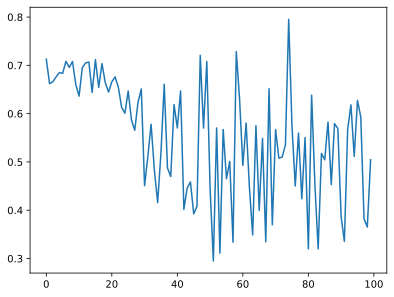

In [67]:
plt.plot(losses);

In [15]:
n_epochs = 100

In [36]:
model(X_train).shape

torch.Size([1197, 1])

In [38]:
preds.shape

(100, 8, 1197, 1)

In [43]:
preds[99, 6,:,:].shape

(1197, 1)

In [44]:
X_train.shape

torch.Size([1197, 11])

In [69]:
activation_funcs = ["sigmoid", "tanh", "relu", "hardshrink","gelu",
                    "leaky_relu", "relu6", "rrelu"]
losses = np.zeros((n_epochs, (len(activation_funcs))))
train_accs = np.zeros((n_epochs, (len(activation_funcs))))
test_accs = np.zeros((n_epochs, (len(activation_funcs))))
preds = np.zeros((n_epochs, len(activation_funcs), X_train.shape[0], 1))
for idx, act_func in tqdm(enumerate(activation_funcs)):
    
    model, loss_func, optim = build_model(act_func)
    losses[:,idx], train_accs[:,idx], test_accs[:,idx] = train_model(model,
                                                                    loss_func, optim,
                                                                    n_epochs)

    preds[:,idx, :] = model(X_train).detach().numpy()

8it [01:19,  9.93s/it]


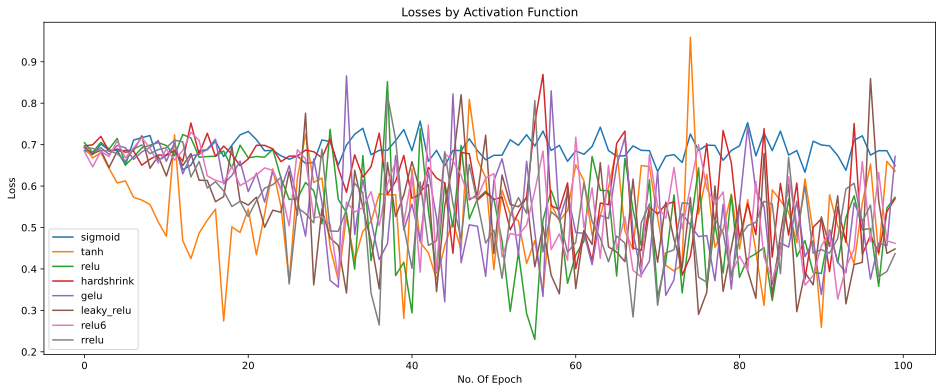

In [82]:
plt.figure(figsize=(16,6))
plt.title("Losses by Activation Function")
plt.xlabel("No. Of Epoch")
plt.ylabel("Loss")
plt.plot(losses);
plt.legend(activation_funcs);

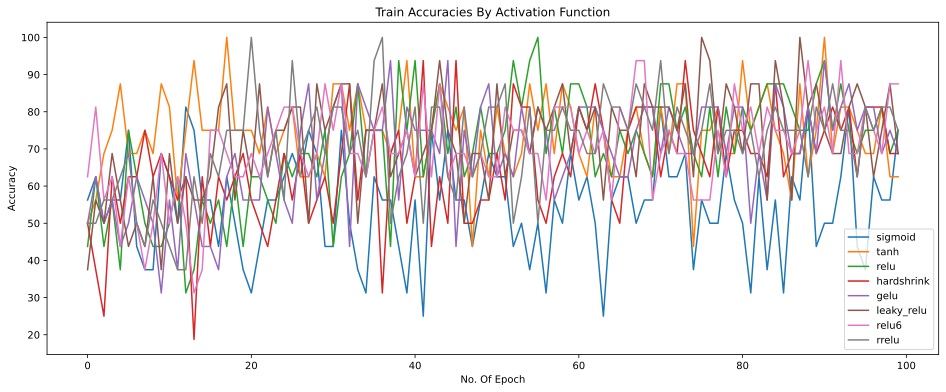

In [86]:
plt.figure(figsize=(16,6))
plt.title("Train Accuracies By Activation Function")

plt.plot(train_accs);
plt.xlabel("No. Of Epoch")
plt.ylabel("Accuracy")
plt.legend(activation_funcs);

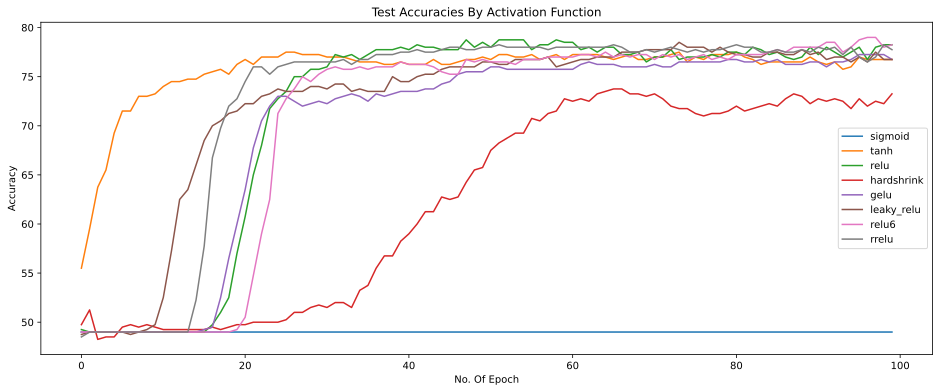

In [87]:
plt.figure(figsize=(16,6))
plt.title("Test Accuracies By Activation Function")

plt.plot(test_accs);
plt.xlabel("No. Of Epoch")
plt.ylabel("Accuracy")
plt.legend(activation_funcs);